<div style="margin-bottom: 15px; padding: 15px; color: #31708e; background-color: #d9edff; border: 1px solid #bce8f1; border-radius: 5px;">
    
<font size=+2>My Information:</font></b>

  Name</b>: [Venkata Sai Kumar Gottumukkala]
  </br>

  Student ID Number</b>:  [862393318]
  </br>
    
Some parts of this notebook are inspired from the Deep Learning Specilization course from [Deeplearning.ai](https://www.deeplearning.ai/courses/deep-learning-specialization/) offered on coursera that I am currently doing along with my CS228 Intro to Deep Learning course at UCR.
</div>

In [1]:
%matplotlib inline
import numpy as np 
import tensorflow as tf
import tensorflow.keras as keras

import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
x_train = x_train / 255.0
x_test = x_test / 255.0

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [4]:
def create_model(num_hidden, num_output, dropout_rate=0.5):
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(28, 28)),
        keras.layers.Dense(num_hidden, activation=tf.nn.relu, kernel_initializer='he_normal'),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(num_output, activation=tf.nn.softmax, kernel_initializer='he_normal')
    ])
    return model

In [5]:
model = create_model(num_hidden=40, num_output=10, dropout_rate=0.5)
model.summary()

Metal device set to: Apple M2 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 40)                31400     
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                410       
                                                                 
Total params: 31,810
Trainable params: 31,810
Non-trainable params: 0
_________________________________________________________________


In [6]:
def model_train(x_train, y_train, P, K):
    train_accs = []
    test_accs = []

    for p in P:
        train_accs_p = []
        test_accs_p = []
        for k in K:
            model = create_model(num_hidden=k, num_output=10, dropout_rate=p)

            optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
            model.compile(optimizer=optimizer,
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])
        
            history = model.fit(x_train, 
                            y_train,  
                            epochs=80,
                            batch_size=1024,
                            verbose=0,
                            validation_data=(x_test, y_test))
        
            train_accs_p.append(history.history['accuracy'])
            test_accs_p.append(history.history['val_accuracy'])
    
        train_accs.append(train_accs_p)
        test_accs.append(test_accs_p)

    return train_accs, test_accs 

## 2.1:
Fix p = 0.0 which is the case of “no dropout regularization”. Plot the test and training accuracy as a function of k. As k increases, does the performance improve? At what k, training accuracy becomes 100%?

In [7]:
def plot_training_accuracy1(train_accs, test_accs, K):
    epochs = len(train_accs[0][0])
    num_k = len(K)
    
    fig, axs = plt.subplots(2, 1, figsize=(8, 8))
    
    # Plot train_acc
    axs[0].set_title('Training Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].grid(True)
    
    max_acc = 0.0  # Initialize max accuracy value
    best_k = None  # Initialize best k value
    for i, k in enumerate(K):
        axs[0].plot(range(1, epochs+1), train_accs[0][i], label=f'k={k}')
        
        # Update max accuracy and best k if a higher accuracy is found
        last_acc = max(train_accs[0][i])
        if last_acc > max_acc:
            max_acc = last_acc
            best_k = k
    axs[0].legend()
    # Display the maximum accuracy and the corresponding k value
    axs[0].text(epochs, max_acc, f'k={best_k}, Max_train_Acc={max_acc:.4f}', 
                horizontalalignment='left', verticalalignment='top')

    # Plot test_acc
    axs[1].set_title('Test Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].grid(True)
    
    max_acc = 0.0  # Initialize max accuracy value
    best_k = None  # Initialize best k value
    for i, k in enumerate(K):
        axs[1].plot(range(1, epochs+1), test_accs[0][i], label=f'k={k}')
        
        # Update max accuracy and best k if a higher accuracy is found
        last_acc = max(test_accs[0][i])
        if last_acc > max_acc:
            max_acc = last_acc
            best_k = k
    axs[1].legend()
    # Display the maximum accuracy and the corresponding k value
    axs[1].text(epochs, max_acc, f'k={best_k}, Max_test_Acc={max_acc:.4f}', horizontalalignment='left', 
                verticalalignment='top')

    plt.tight_layout()
    plt.show()


2023-06-06 20:02:16.234422: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


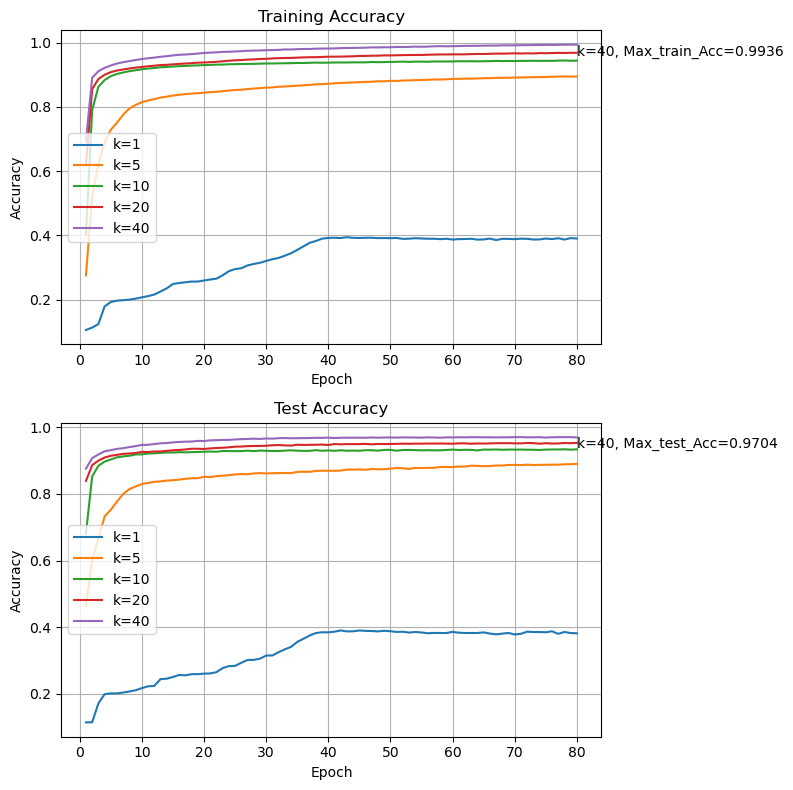

In [8]:
train_accuracy, test_accuracy = model_train(x_train, y_train, P = [0.0], K = [1, 5, 10, 20, 40])

plot_training_accuracy1(train_accuracy, test_accuracy, K=[1, 5, 10, 20, 40])

##### As k increases, does the performance improve? 
1. Yes, as num of hidden units(K) increases the performance of the model increases due to model learning representations of the data.
##### At what k, training accuracy becomes 100%?
1. Training accuracy has reached __99.36%__ for the __K = 40__ for __80 epochs__. 

## 2.2:
Plot the training accuracy as a function of k and for different p ∈ P on the same plot. What is the role of p on training accuracy? When p is smaller, is it easier to optimize or more difficult? For each choice of p, determine at what choice of k, training accuracy becomes 100%.

In [9]:
def plot_training_accuracy(train_accs, K, P):
    epochs = len(train_accs[0][0])
    num_p = len(P)

    fig, axs = plt.subplots(num_p, 1, figsize=(8, 4*num_p), sharex=True)

    for i, p in enumerate(P):
        ax = axs[i]
        ax.set_title(f'p={(1 - p):.1f}')
        ax.set_ylabel('Accuracy')
        ax.grid(True)

        max_acc = 0.0  # Initialize max accuracy value
        best_k = None  # Initialize best k value
        for j, k in enumerate(K):
            ax.plot(range(1, epochs+1), train_accs[i][j], label=f'k={k}')

            # Update max accuracy and best k if a higher accuracy is found
            last_acc = max(train_accs[i][j])
            if last_acc > max_acc:
                max_acc = last_acc
                best_k = k
        ax.legend()
        # Display the highest last accuracy value and the corresponding k value
        ax.text(epochs, max_acc, f'k={best_k}, acc={max_acc:.4f}', horizontalalignment='left', verticalalignment='top')

    axs[-1].set_xlabel('Epoch')

    plt.tight_layout()
    plt.show()

Training Accuracy Plots:


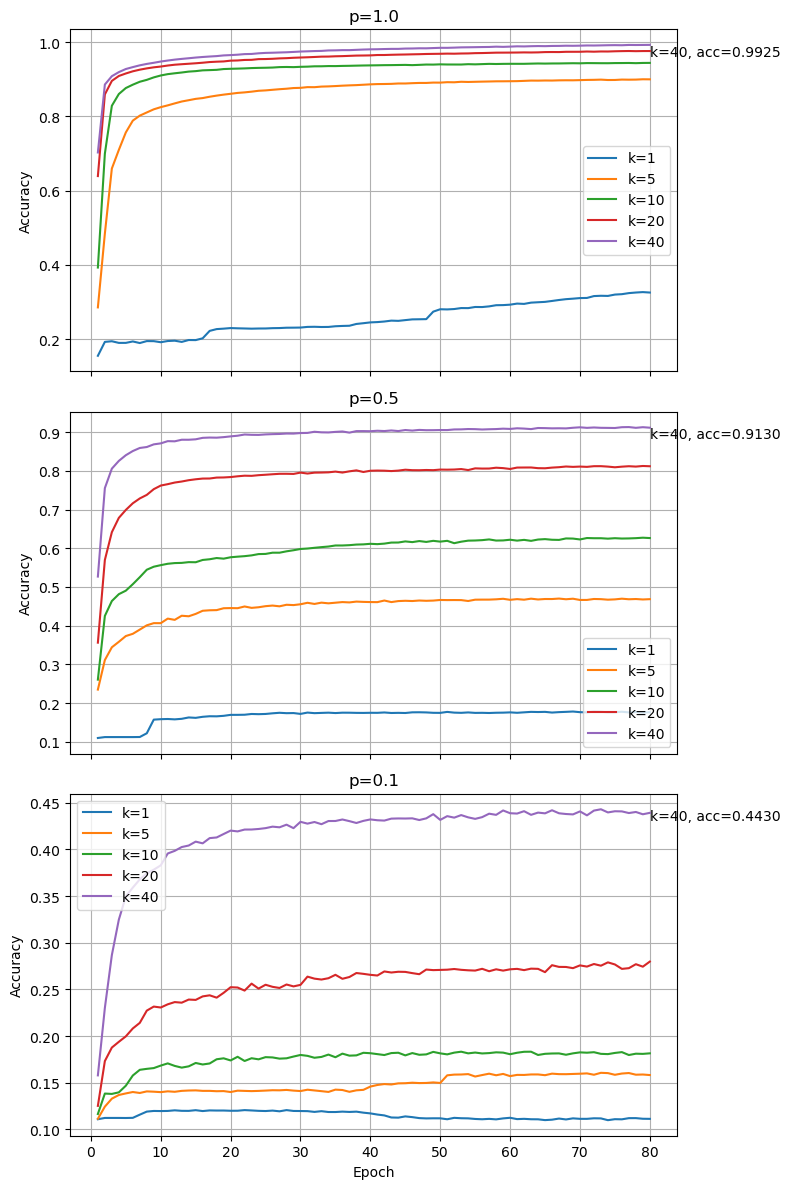

In [10]:
train_accuracy1, test_accuracy1 = model_train(x_train, y_train, P = [0.0, 0.5, 0.9], K = [1, 5, 10, 20, 40])

print('Training Accuracy Plots:')
plot_training_accuracy(train_accuracy1, K = [1, 5, 10, 20, 40], P = [0.0, 0.5, 0.9])

##### What is the role of p on training accuracy? Considered the (p = 1-P) according to tensorflow setting for answering Questions!
1. Increasing p that is rate of dropout, decreases the training accuracy, which was due to regularization effect introduced due to dropping of some hidden units. Dropout rate plays a role in controlling overfitting and improving the generalization capability of a model.

##### When p is smaller, is it easier to optimize or more difficult? 
1. When the dropout rate (p) is smaller, it is generally more difficult to optimize the model. A smaller regularization rate means less regularization, allowing the model to have more parameters and potentially overfit the training data. This increased complexity can make it harder for the model to generalize well to unseen data and can lead to overfitting.

##### For each choice of p, determine at what choice of k, training accuracy becomes 100%.
1. Training accuracy becomes __99.25%__ for the choice of __(p, k)==(0.0, 40)__. Where __p=0.0__ corresponds to __no regularization effect__ and k=40 indicates 40 hidden units.
2. According to P given in the __pdf__ training accuracy becomes 100% for the choice of __(p, k)==(1.0, 40)__.

## 2.3:
Plot the test accuracy as a function of k and for different p ∈ P on the same plot. Does dropout help with the test accuracy? For which (k,p) configuration do you achieve the best test accuracy?

Test Accuracy Plots:


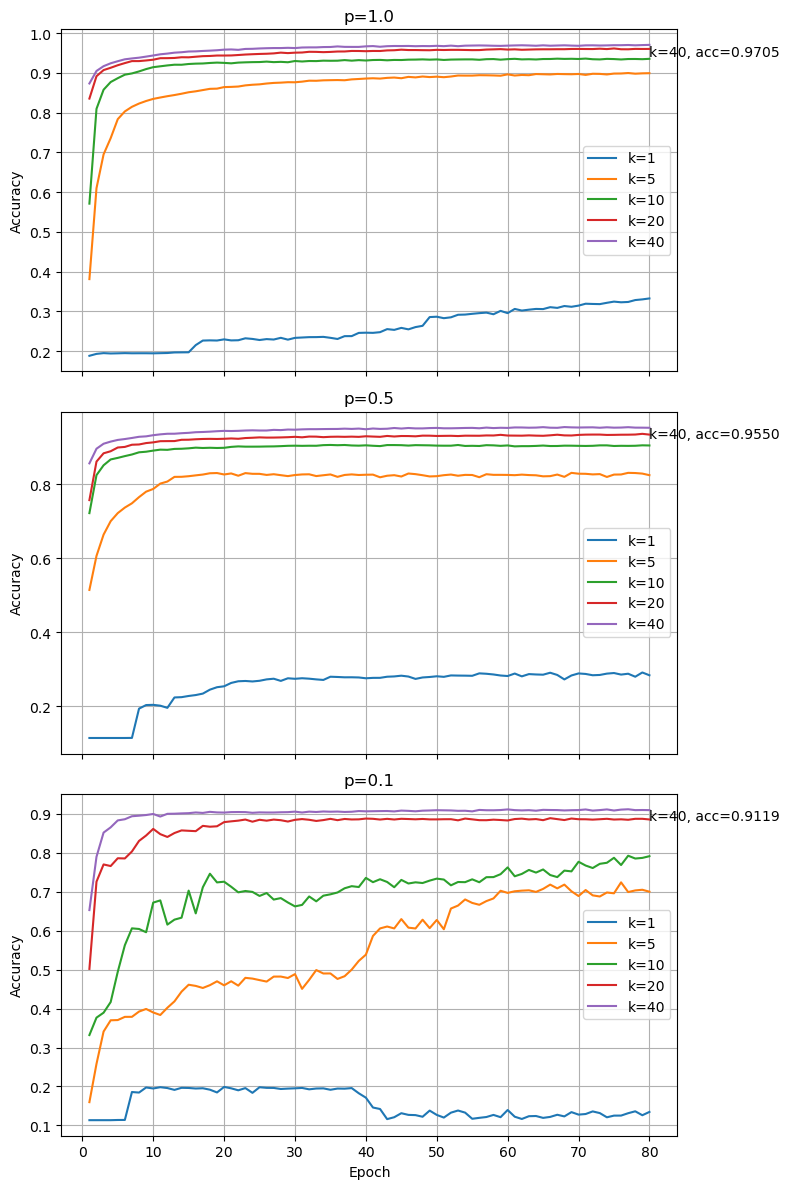

In [11]:
print('Test Accuracy Plots:')
plot_training_accuracy(test_accuracy1, K = [1, 5, 10, 20, 40], P = [0.0, 0.5, 0.9])

##### Does dropout help with the test accuracy? 
1. Dropout regularization can, in fact, assist enhance test accuracy. Dropout is a regularization strategy that seeks to reduce overfitting by setting a percentage of units or weights to zero at random during training. Dropout provides noise into the model and stops it from depending too much on specific units or weights, driving it to learn more resilient and generic representations.

2. Dropout is normally disabled during testing or inference, and all units or weights are used. The weights, however, are scaled by the dropout rate __1/(1-p)__ to guarantee that the model's predicted output stays the same as during training. This is referred to as "inverted dropout."
##### For which (k,p) configuration do you achieve the best test accuracy?
1. Best test accuracy __97.05%__ was achieved for the choice of __(p, k)==(1.0, 40)__. Where __p=1.0 corresponds to no regularization effect__ and k=40 indicates 40 hidden units.

## 3: Adding Noise:

In [12]:
# Create a copy of the original labels
y_train_incorrect = np.copy(y_train)

# Calculate the number of examples to assign incorrect labels
num_examples = int(0.4 * len(y_train))

# Generate random indices for the examples to assign incorrect labels
indices = np.random.choice(len(y_train), num_examples, replace=False)

# Generate random incorrect labels that are not equal to true labels
incorrect_labels = np.random.randint(low=0, high=10, size=num_examples)
mask = incorrect_labels == y_train[indices]
while np.any(mask):
    incorrect_labels[mask] = np.random.randint(low=0, high=10, size=np.sum(mask))
    mask = incorrect_labels == y_train[indices]

# Assign the incorrect labels to the selected examples
y_train_incorrect[indices] = incorrect_labels

print(np.count_nonzero(y_train_incorrect != y_train))

24000


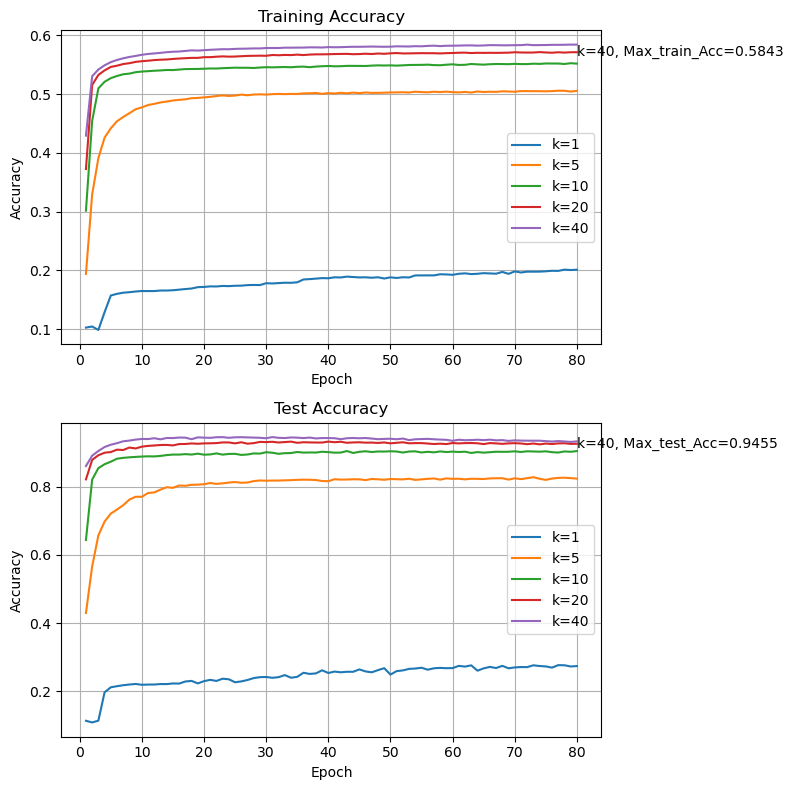

In [13]:
train_accuracy, test_accuracy = model_train(x_train, y_train_incorrect, P = [0.0], K = [1, 5, 10, 20, 40])

plot_training_accuracy1(train_accuracy, test_accuracy, K=[1, 5, 10, 20, 40])

##### As k increases, does the performance improve? 
1. Yes, as num of hidden units(K) increases the performance of the model increases due to model learning representations of the data.
##### At what k, training accuracy becomes 100%?
1. Training accuracy has __never__ reached 100%. Best train_accuracy was __58.43%__.

Training Accuracy Plots:


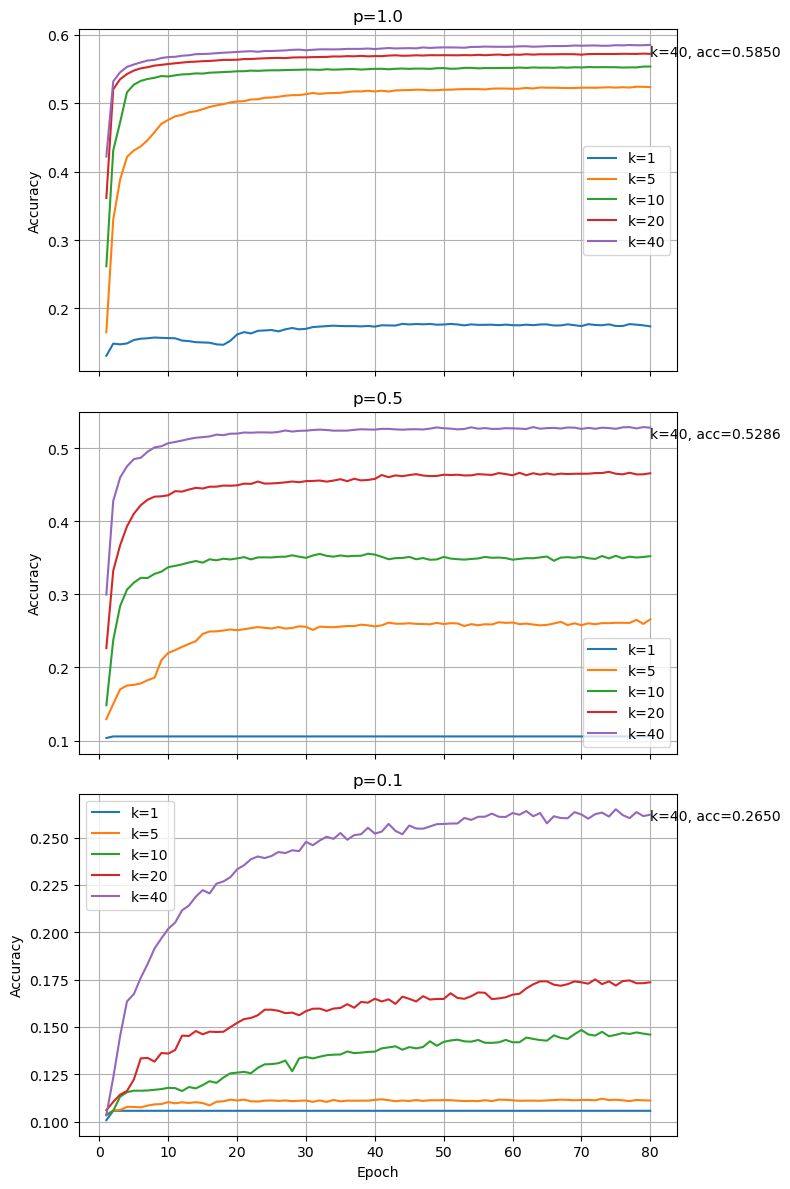

In [14]:
train_accuracy1, test_accuracy1 = model_train(x_train, y_train_incorrect, P = [0.0, 0.5, 0.9], K = [1, 5, 10, 20, 40])

print('Training Accuracy Plots:')
plot_training_accuracy(train_accuracy1, K = [1, 5, 10, 20, 40], P = [0.0, 0.5, 0.9])

##### What is the role of p on training accuracy? Considered the (p = 1-P) according to tensorflow setting for answering Questions!
1. Increasing p that is rate of dropout, decreases the training accuracy, which was due to regularization effect introduced due to dropping of some hidden units. Dropout rate plays a role in controlling overfitting and improving the generalization capability of a model.

##### When p is smaller, is it easier to optimize or more difficult? 
1. When the dropout rate (p) is smaller, it is generally more difficult to optimize the model. A smaller regularization rate means less regularization, allowing the model to have more parameters and potentially overfit the training data. This increased complexity can make it harder for the model to generalize well to unseen data and can lead to overfitting.

##### For each choice of p, determine at what choice of k, training accuracy becomes 100%.
1. Training accuracy __never reached__ __100%__. Best trainng accuracy was __58.50%__ for choice of __(p, k)==(1.0, 40)__.

Test Accuracy Plots:


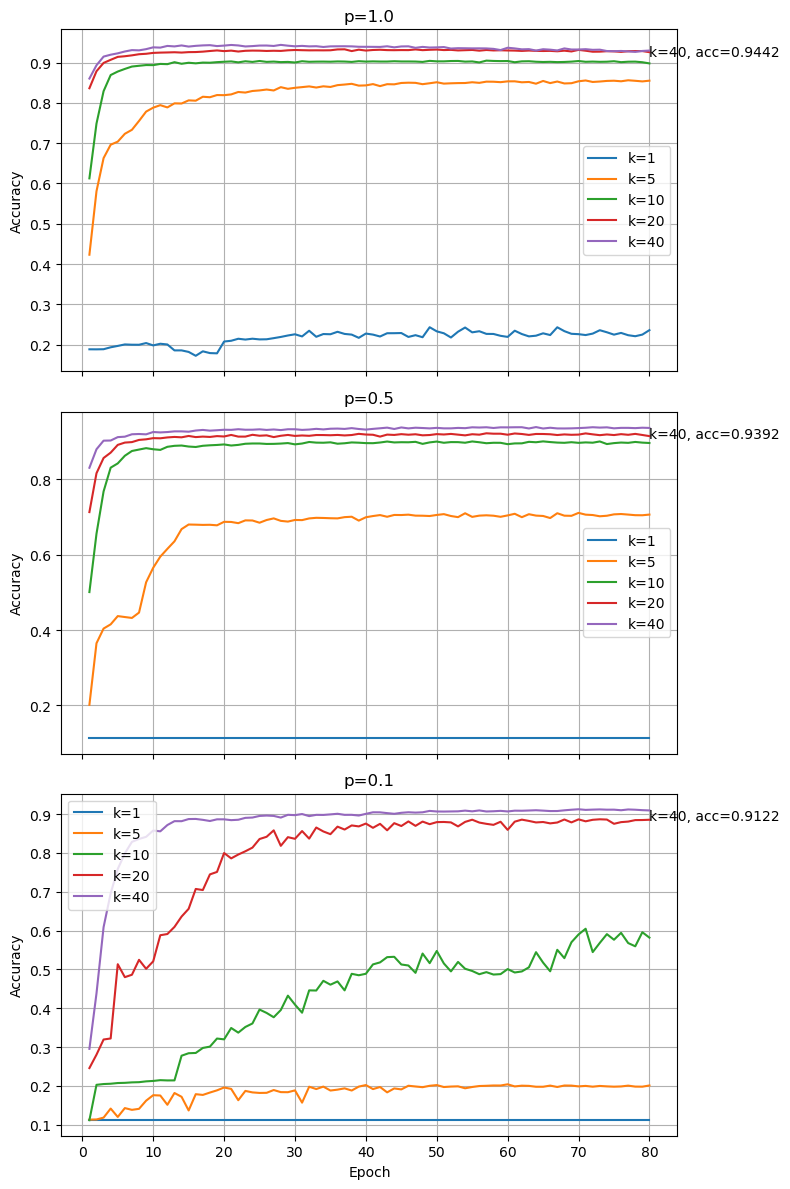

In [15]:
print('Test Accuracy Plots:')
plot_training_accuracy(test_accuracy1, K = [1, 5, 10, 20, 40], P = [0.0, 0.5, 0.9])

##### Does dropout help with the test accuracy? 
1. Dropout regularization can, in fact, assist enhance test accuracy. Dropout is a regularization strategy that seeks to reduce overfitting by setting a percentage of units or weights to zero at random during training. Dropout provides noise into the model and stops it from depending too much on specific units or weights, driving it to learn more resilient and generic representations.

2. Dropout is normally disabled during testing or inference, and all units or weights are used. The weights, however, are scaled by the dropout rate __1/(1-p)__ to guarantee that the model's predicted output stays the same as during training. This is referred to as "inverted dropout."
##### For which (k,p) configuration do you achieve the best test accuracy?
1. Best test accuracy __94.42%__ was achieved for the choice of __(p, k)==(1.0, 40)__. Where __p=1.0 corresponds to no regularization effect__ and k=40 indicates 40 hidden units.

## 4. Comment:
### How does noise change things? 
1. __Regularization__: Noise can operate as a regularization approach by injecting unpredictability during training. It prevents overfitting by lowering the model's reliance on specific traits or connections, favoring more generic learning.

2. __Robustness__: Noise can make a model more resistant to fluctuations and disruptions in the input data. It promotes the model to learn features that are less susceptible to noise, resulting in improved generalization performance. 

3. __Exploration__: During training, noise may be used as a source of exploration, assisting the model in exploring new areas of the parameter space. This is especially important for breaking out of local optima and discovering superior alternatives.

### For which setup dropout is more useful?
1. __Useful Ness of Dropout in the two setups__: Dropout regularization is more useful when there is noise or uncertainty in the data. In the case where 40% of the training examples have incorrect labels, dropout regularization was particularly helpful. 

2. It helped model achive more than __91.22%__ validation accuracy even when trained on partially wrong labels dataset using __rate of 0.9__. The model confronts a more difficult challenge of learning from partially inaccurate labels with using of label noise. Dropout regularization can reduce overfitting and encourage the model to learn more robust and generic representations, which can help alleviate the detrimental impact of noisy labels.

### Cases where dropout is more useful:
1. __Deep Neural Networks__: Dropout is frequently employed in deep neural networks with a large number of layers and parameters. Dropout can successfully regularize and enhance generalization performance in these models, which are prone to overfitting.

2. __Limited Training Data__: When the training dataset is small, the danger of overfitting increases. Dropout can assist to solve this problem by introducing regularization, lowering overfitting, and boosting the model's capacity to generalize to new, previously unknown data.

3. __Ensembling__: Dropout is a type of model ensembling in which multiple subnetworks are trained concurrently with distinct subsets of units active. This ensemble learning aids in the reduction of model variance and the improvement of overall performance. 

### References Used for comments: 
1. [Improving neural networks by preventing co-adaptation of feature detectors](https://arxiv.org/pdf/1207.0580.pdf)
2. [Dropout: A Simple Way to Prevent Neural Networks from
Overfitting](https://dl.acm.org/doi/pdf/10.5555/2627435.2670313)
3. [Learning Deep Networks from Noisy Labels with Dropout Regularization
](https://arxiv.org/abs/1705.03419)
4. [Keras_Dropout_Implementation](https://github.com/keras-team/keras/blob/v2.12.0/keras/layers/regularization/dropout.py#L29-L135)

### References used for tensorflow coding:
1. [AI and Machine Learning for Coders](https://www.oreilly.com/library/view/ai-and-machine/9781492078180/)

### Reference Video about dropout and adding noise:
1. [Brains, Sex, and Machine Learning Google talks by Geoffrey Hinton](https://www.youtube.com/watch?v=DleXA5ADG78)